<a href="https://colab.research.google.com/github/bettytan123/Sample-Size-Calculation/blob/main/Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
############################################
## This script will simulate data from known statistical distirbutions; then estimate GAN and sample from it
## march 7 4pm hhh
## Authors: Betty and Chris

## Date: February 2023
############################################

In [3]:
############################################
## Installations of required modules not default available on COLAB compute software stack
############################################
! pip install sdv --quiet
! pip install --upgrade scipy --quiet
!pip install sinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.7/140.7 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 86.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 KB 9.2 MB/s eta 0:00:00
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-

In [4]:

########################
## Import dependency packages
########################

## Import SDV for GANs and sampling mechanisms, etc.
from sdv.tabular import CTGAN

## Import pandas for data structures
import pandas as pd

## Import numpy for numerical computing
import numpy as np

## Import scipy for statistical distirbution function 
import scipy

## For plotting
import matplotlib.pyplot as plt

## For timing
from time import time

## Random Numbers
import random

# For progress bars
from tqdm.notebook import tqdm, trange

# Do not display warnings (bad practice)
import warnings
warnings.filterwarnings("ignore")

# For CUDA enabled/accelerated computation on the GPU 
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from io import StringIO

sns.set_style('darkgrid')

In [5]:
## Set seed of everything
np.random.seed(614)
torch.manual_seed(614)
random.seed(614)
scipy.stats.rv_continuous.random_state = 614

In [6]:
#####################################
##
## Sample Size for Precision of a Continuous Normal Random Variable --- by Mathemtical Theory
##
#####################################

In [7]:
scipy.stats.norm.ppf(q=0.025, loc=0, scale=1)

-1.9599639845400545

In [8]:
## Sample size by math

def samp_size_corr_coef(alpha, beta, correlation):
    C = 0.5 * np.log( (1+correlation)/(1-correlation) )
    n = ((scipy.stats.norm.ppf(q=alpha/2, loc=0, scale=1)+ scipy.stats.norm.ppf(q=beta, loc=0, scale=1))/C)**2 +3
    return(n)


In [9]:
samp_size_corr_coef(alpha=0.05,beta=0.1,correlation=0.3) #113


112.67809433031636

In [10]:
# input the mu_vector and sigma_matrix 
sigma_matrix = np.array([1,0.3,0.3,1]).reshape((2,2))
sigma_matrix

array([[1. , 0.3],
       [0.3, 1. ]])

In [11]:
mu_vec = np.array([0,0])
mu_vec

array([0, 0])

In [12]:
# Testing out the code working validity in the defination 
dat = scipy.stats.multivariate_normal.rvs(size=10, mean=mu_vec, cov=sigma_matrix)
dat
    

array([[-0.93665003,  0.3463049 ],
       [-0.3523312 ,  1.50869786],
       [ 0.52233849,  1.41148079],
       [-1.49011162, -1.12986384],
       [-0.41165384,  0.45622653],
       [ 0.48234941, -0.65416244],
       [-1.33211611, -1.0871453 ],
       [-0.59681424,  0.73200218],
       [-1.25909255, -0.25540589],
       [-1.07451845,  1.27923581]])

In [13]:
res = scipy.stats.pearsonr(x=dat[:,0], y=dat[:,1], alternative='two-sided')
res

PearsonRResult(statistic=0.41848560236656773, pvalue=0.2287397023800059)

In [14]:
# p value can be extract by 
res[1]

0.2287397023800059

In [15]:
#################################
##
## Sample Size for Precision of a Corelation of multivariate Normal Random Variable --- by numerical simulation
##
################################

In [16]:

def corr_ci_samp_size(n, mu_vec, sigma_matrix):
    
    ## Generate random data from multivariate normal 
    dat = scipy.stats.multivariate_normal.rvs(size=n, mean=mu_vec, cov=sigma_matrix)
    ## Analyze generated/simulated data
    res = scipy.stats.pearsonr(x=dat[:,0], y=dat[:,1], alternative='two-sided')
    ## Grab the p-value, and correlation
    pval = res[1]
    corr = res[0]
    ## Tag whether one result is stat significant or not 
    tag = np.where(pval<0.05, 1, 0)
    # Return the estimate and the CI to the user
    # this p value give you the mena p value 
    out = pd.DataFrame({'corr': [corr], 'pval': [pval], 'tag': [tag]})
    return(out)




In [17]:
corr_ci_samp_size(n=113, mu_vec=mu_vec, sigma_matrix=sigma_matrix)

,corr,pval,tag
0,0.304032,0.001061,1


In [18]:

## Replicate above function number of simulation replicate times to get power 

# parameter available  
n = int(np.ceil(samp_size_corr_coef(alpha=0.05,beta=0.1,correlation=0.3)))
mu_vec = np.array([0,0])
sigma_matrix = np.array([1,0.3,0.3,1]).reshape((2,2))

## Number simulation replicates
n_rep = 1000

## Simulate n_rep copies of sample size trials
sim_out = []

## Loop over number simulation replicates, storing results in list
t0 = time()

for i in trange(0, n_rep):
    sim_out.append(corr_ci_samp_size(n=n, mu_vec=mu_vec, sigma_matrix=sigma_matrix))

t1 = time()
runtime = t1 - t0

### Aggregate results into dataframe
sim_df = pd.concat(sim_out)

#Calculate power of each column in the array #axis means column power 
sim_power = np.mean(sim_df, axis=0)
sim_power

  0%|          | 0/1000 [00:00<?, ?it/s]

corr    0.295674
pval    0.024394
tag     0.901000
dtype: float64

In [19]:
## Collect the sample size simulation results into a single dataFrame
sim_results = pd.DataFrame({
    'runtime': [runtime],
    'correlation': [sim_power[0]],
    'pvalue': [sim_power[1]],
    'power': [sim_power[2]]
})

sim_results

,runtime,correlation,pvalue,power
0,3.040987,0.295674,0.024394,0.901


In [20]:
#############################################################
##
## Sample size estimation by GAN simulation
##
#############################################################

In [21]:
import sys
 
path = 'logs.txt'
sys.stdout = open(path, 'w')

In [22]:
## Function to train a GAN model to simulated correlation data (with parms: pop_n, pop_mu_vec, pop_sigma_matrix)
def train_gan_model_corr(pop_n, pop_mu_vec, pop_sigma_matrix):
    ## Set seed of everything
    np.random.seed(614)
    torch.manual_seed(614)
    random.seed(614)
    scipy.stats.rv_continuous.random_state = 614

    ## Simulate data as input to GAN
    x = scipy.stats.multivariate_normal.rvs(size=pop_n, mean=pop_mu_vec, cov=pop_sigma_matrix)
    
    #   ## Convert vector to pandas dataFrame
    x_pd = pd.DataFrame(x, columns=[f'x{i}' for i in range(x.shape[1])])

    ## Feed the simulated data into SDV and sample synthetic data from the fitted GAN
    model = CTGAN(verbose=True, epochs=2000)

    ## Fit a GAN to the simulated data from above
    model.fit(x_pd)
    
    ## Return the learned model
    out = [model, x_pd]

    return out


In [23]:
# %%time
# %%capture output

## Parameters of binormal parent distribution
pop_n = 50_000
pop_mu_vec = np.array([0.0,0.0])
pop_sigma_matrix = np.array([1.0, 0.3, 0.3, 1.0]).reshape((2,2))

## Get the learned GAN model --- after training 
t0 = time()
train_gan = train_gan_model_corr(pop_n=pop_n , pop_mu_vec=pop_mu_vec, pop_sigma_matrix=pop_sigma_matrix)
t1 = time()
fit_time = t1 - t0
fit_time

3047.1479003429413

In [24]:
with open('logs.txt') as file:
    lines = file.readlines()

In [25]:
output = "".join(lines)
output

'Epoch 1, Loss G: -0.3720,Loss D: -0.0618\nEpoch 2, Loss G: -0.7715,Loss D: -0.0292\nEpoch 3, Loss G: -0.9462,Loss D:  0.1478\nEpoch 4, Loss G: -0.8292,Loss D: -0.0309\nEpoch 5, Loss G: -0.9152,Loss D:  0.0051\nEpoch 6, Loss G: -1.0126,Loss D: -0.0374\nEpoch 7, Loss G: -1.0111,Loss D: -0.0390\nEpoch 8, Loss G: -1.0439,Loss D: -0.0633\nEpoch 9, Loss G: -1.1559,Loss D:  0.0381\nEpoch 10, Loss G: -1.2217,Loss D: -0.0841\nEpoch 11, Loss G: -1.2310,Loss D: -0.0426\nEpoch 12, Loss G: -1.2485,Loss D: -0.0744\nEpoch 13, Loss G: -1.2818,Loss D: -0.0130\nEpoch 14, Loss G: -1.3563,Loss D: -0.0172\nEpoch 15, Loss G: -1.2867,Loss D: -0.0589\nEpoch 16, Loss G: -1.2749,Loss D: -0.0618\nEpoch 17, Loss G: -1.3454,Loss D: -0.1386\nEpoch 18, Loss G: -1.3783,Loss D: -0.1391\nEpoch 19, Loss G: -1.3499,Loss D:  0.0133\nEpoch 20, Loss G: -1.3849,Loss D: -0.1505\nEpoch 21, Loss G: -1.3548,Loss D: -0.1300\nEpoch 22, Loss G: -1.4029,Loss D: -0.1014\nEpoch 23, Loss G: -1.3570,Loss D: -0.0105\nEpoch 24, Loss G: -

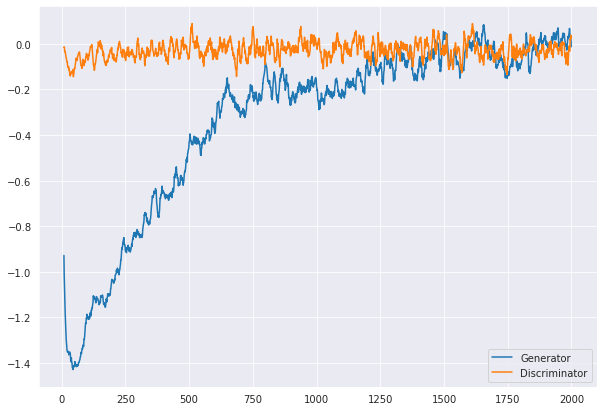

In [26]:
output = "".join(lines)
logs = StringIO(str(output))
window = 10 # window size for the moving average, window=1 gets you the original series

df = pd.read_csv(logs, sep=",", names=['Epochs', 'Loss G', 'Loss D'])

# I think a regex would be better here
df['Loss G'] = df['Loss G'].apply(lambda x: float(x.split(':')[1]))
df['Loss D'] = df['Loss D'].apply(lambda x: float(x.split(':')[1]))

plt.figure(figsize=(10,7))

# Plot with a moving average so it is less noisy
plt.plot(df['Loss G'].rolling(window=window).mean(), label="Generator")
plt.plot(df['Loss D'].rolling(window=window).mean(), label="Discriminator")

plt.legend()
plt.show()

In [27]:
# logs = StringIO(str(output))
# window = 10 # window size for the moving average, window=1 gets you the original series

# df = pd.read_csv(logs, sep=",", names=['Epochs', 'Loss G', 'Loss D'])

# # I think a regex would be better here
# df['Loss G'] = df['Loss G'].apply(lambda x: float(x.split(':')[1]))
# df['Loss D'] = df['Loss D'].apply(lambda x: float(x.split(':')[1]))

# plt.figure(figsize=(10,7))

# # Plot with a moving average so it is less noisy
# plt.plot(df['Loss G'].rolling(window=window).mean(), label="Generator")
# plt.plot(df['Loss D'].rolling(window=window).mean(), label="Discriminator")

# plt.legend()
# plt.show()

In [28]:
model_ = train_gan[0]

In [29]:
## Summarize moments of the "parent distribution" used to simulate the synthetic GAN data
x_parent = train_gan[1]

x_parent.describe()

,x0,x1
count,50000.000000,50000.000000
mean,0.000842,-0.005566
std,0.997466,1.000031
min,-5.389252,-4.172570
25%,-0.665661,-0.677765
50%,0.002842,-0.003837
75%,0.670605,0.670629
max,4.325305,3.836361


In [30]:
## Parameter for specifying size of the simulated/synthetic data generated from the GAN
sim_n = int(np.ceil(samp_size_corr_coef(alpha=0.05,beta=0.1,correlation=0.3)))
sim_n

113

In [31]:
## Function to analyze data from the sampled model 
def corr_power_samp_size_gan(m, sim_n):
    ## Generate random data --- sampling from the trained GAN which approximates the normal probability generating function
    dat = m.sample(num_rows=sim_n).values
    ## Analyze generated/simulated data
    res = scipy.stats.pearsonr(x=dat[:,0], y=dat[:,1], alternative='two-sided')
    
    ## Extract the estimate and CI
    pval = res[1]
    corr = res[0]
    tag = np.where(pval<0.05, 1, 0)
   
    # Return the estimate and the CI to the user
    out = pd.DataFrame({'corr': [corr], 'pval': [pval], 'tag': [tag]})
    return(out)


In [32]:
## Replicate above function number of simulation replicate times

## Number simulation replicates
n_rep = 1000

## Simulate n_rep copies of sample size trials
gan_out = []

## Loop over number simulation replicates, storing results in list
t0 = time()

for i in trange(0, n_rep):
    gan_out.append(corr_power_samp_size_gan(m=model_, sim_n=sim_n))

t1 = time()
runtime = t1 - t0

## Aggregate results into dataframe
gan_df = pd.concat(gan_out)

## Calculate means of each column in the array #axis means column mean 
gan_power = np.mean(gan_df, axis=0)



  0%|          | 0/1000 [00:00<?, ?it/s]

In [33]:
gan_power

corr    0.277701
pval    0.033275
tag     0.854000
dtype: float64

In [34]:
## Collect results of the GAN based sample size calculations
gan_results = pd.DataFrame({
    'runtime': [runtime],
    'correlation': [gan_power[0]],
    'pvalue': [gan_power[1]],
    'power': [gan_power[2]]
})

gan_results



,runtime,correlation,pvalue,power
0,25.949357,0.277701,0.033275,0.854


In [35]:
#########################################################################
##
##
## Below we investgiate finite sample properties of three methods for estimating sample size for a continuous CI from normal distribution
##    1) Theory or analytic formula
##    2) Simulation (from normal probability generating model)
##    3) Simulation (from GAN approximating parent normal probability generating model)
##
##
#########################################################################

In [36]:
###########################
## Create parameter grid
###########################
from itertools import product

def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())], columns=dictionary.keys())

dictionary = {'alpha': [0.05], 
              'corr': np.arange(0.1, 0.5, 0.1), 
              'beta': [0.05, 0.1, 0.2, 0.3]}

param_df = expand_grid(dictionary)
param_df

,alpha,corr,beta
0,0.05,0.1,0.05
1,0.05,0.1,0.10
2,0.05,0.1,0.20
3,0.05,0.1,0.30
4,0.05,0.2,0.05
5,0.05,0.2,0.10
6,0.05,0.2,0.20
7,0.05,0.2,0.30
8,0.05,0.3,0.05
9,0.05,0.3,0.10


In [37]:
#################
## 1) Sample Size for Continuous CI by Theory or Analytic Formula
#################
samp_size_theory_list = []

for i in np.arange(param_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    n = samp_size_corr_coef(alpha=param_df.loc[i, 'alpha'], 
                          correlation=param_df.loc[i, 'corr'],
                          beta=param_df.loc[i, 'beta'])
    ## Round to largest integer
    n_ = str(np.round(np.ceil(n),0))
    ## Append sample size to list
    samp_size_theory_list.append(n_)

samp_size_theory_df = pd.concat([param_df, pd.Series(samp_size_theory_list)], axis=1)
samp_size_theory_df.columns = ['alpha','corr','beta','n_theory']
samp_size_theory_df

,alpha,corr,beta,n_theory
0,0.05,0.1,0.05,1294.0
1,0.05,0.1,0.10,1047.0
2,0.05,0.1,0.20,783.0
3,0.05,0.1,0.30,617.0
4,0.05,0.2,0.05,320.0
5,0.05,0.2,0.10,259.0
6,0.05,0.2,0.20,194.0
7,0.05,0.2,0.30,154.0
8,0.05,0.3,0.05,139.0
9,0.05,0.3,0.10,113.0


In [38]:
########################
## 2) Sample Size for Power by Simulation from multivariate Distribution
########################

In [39]:
def corr_power_samp_size(corr, n):
    
    ## Generate random data
    sigma_matrix = np.array([1,corr,corr,1]).reshape((2,2))
    mu_vec = np.array([0,0])
    dat = scipy.stats.multivariate_normal.rvs(size=n, mean=mu_vec, cov=sigma_matrix)
    ## Analyze generated/simulated data
  
    res = scipy.stats.pearsonr(x=dat[:,0], y=dat[:,1], alternative='two-sided')

    ## Extract the estimate and CI
    pval = res[1]
    corr = res[0]
    tag = np.where(pval<0.05, 1, 0)
    
    # Return the estimate and the CI to the user
    # [] make it a list instead of scalar
    out = pd.DataFrame({'corr': [corr], 
                        'pval': [pval], 
                        'tag': [tag]})
    return(out)


In [40]:
corr_power_samp_size(corr=0.3, n=113)

,corr,pval,tag
0,0.358674,0.000096,1


In [41]:
##
## Replicate above function to compute expected CI width, for continuous mean, at various parm values (mu, std, n) over number sim replicated (n_rep)
##
def corr_power_samp_size_sim( corr, n, n_rep):

    ## Simulate n_rep copies of sample size trials
    sim_out = []

    ## Loop over number simulation replicates, storing results in list
    t0 = time()

    for i in trange(0, n_rep):
        sim_out.append(corr_power_samp_size(corr=corr, n=n))

    t1 = time()
    runtime = t1 - t0

    ### Aggregate results into dataframe
    sim_df = pd.concat(sim_out)

    ## Calculate means of each column in the array 
    sim_power = np.mean(sim_df, axis=0)

    ## Return expect width 
    sim_result = pd.DataFrame({
    'runtime': [runtime],
    'correlation': [sim_power[0]],
    'pvalue': [sim_power[1]],
    'power': [sim_power[2]]
})

    return sim_result


In [42]:
corr_power_samp_size_sim( corr=0.3, n=113,n_rep= 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

,runtime,correlation,pvalue,power
0,2.550091,0.296969,0.019771,0.901


In [43]:
## Loop over theoretical table, to use simulation to understand relationship between (n, corr n_rep) etc.
samp_size_sim_list = []

## 1000 simulation replicates; reduces computational burden
n_rep = 1000

t0 = time()

for i in np.arange(samp_size_theory_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    power_value = corr_power_samp_size_sim(n=int(float(samp_size_theory_df.loc[i, 'n_theory'])), 
                          corr= samp_size_theory_df.loc[i, 'corr'],
                          n_rep=n_rep)
    ## Round to largest integer
    #value 0 give you elment change from data frame to numebr 
    power_value_ = power_value['power'].values[0]
    #power_width_ = power_width.tag
    ## Append sample size to list
    samp_size_sim_list.append(power_value_)

t1 = time()
sim_time = t1-t0

## Compile results into dataFrame
samp_size_sim_df = pd.concat([samp_size_theory_df, pd.Series(samp_size_sim_list)], axis=1)
samp_size_sim_df.columns = ['alpha','corr','beta','n_theory','power_width_sim']
samp_size_sim_df

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,alpha,corr,beta,n_theory,power_width_sim
0,0.05,0.1,0.05,1294.0,0.947
1,0.05,0.1,0.10,1047.0,0.906
2,0.05,0.1,0.20,783.0,0.796
3,0.05,0.1,0.30,617.0,0.709
4,0.05,0.2,0.05,320.0,0.956
5,0.05,0.2,0.10,259.0,0.898
6,0.05,0.2,0.20,194.0,0.806
7,0.05,0.2,0.30,154.0,0.732
8,0.05,0.3,0.05,139.0,0.952
9,0.05,0.3,0.10,113.0,0.907


In [44]:
## Timing for the simulation experiments
sim_time

37.942230463027954

In [45]:
########################
## 3) Sample Size for Continuous CI by Generative Adversarial Network (GAN) from a (parent) Normal Distribution
########################

In [46]:
## Function to train a GAN model to simulated normal data (with parms: mean, sd, n)
def train_gan_model_corr(pop_n, pop_mu_vec, pop_sigma_matrix):
    ## Set seed of everything
    np.random.seed(614)
    torch.manual_seed(614)
    random.seed(614)
    scipy.stats.rv_continuous.random_state = 614

    ## Simulate data as input to GAN
    x = scipy.stats.multivariate_normal.rvs(size=pop_n , mean=pop_mu_vec, cov=pop_sigma_matrix)
    ##
    #   ## Convert vector to pandas dataFrame
    # x_pd = pd.DataFrame({'x': x}) #need two column array 
    x_pd = pd.DataFrame(x, columns=['x0', 'x1'])

    ## Feed the simulated data into SDV and sample synthetic data from the fitted GAN
    model = CTGAN(verbose=False, epochs=2000)

    ## Fit a GAN to the simulated data from above
    model.fit(x_pd)
    
    ## Return the learned model
    out = [model, x_pd]

    return out




In [52]:
##
## Replicate above function to compute expected CI width, for continuous mean, at various parm values (mu, std, n) over number sim replicated (n_rep)
##
def corr_power_samp_size_gan(pop_n, pop_mu_vec, pop_sigma_matrix, sim_n,n_rep):

    ## Get the learned GAN model --- after training 
    t0 = time()
    train_gan = train_gan_model_corr(pop_n=pop_n, pop_mu_vec=pop_mu_vec, pop_sigma_matrix=pop_sigma_matrix)
    t1 = time()
    fit_time = t1 - t0
    #fit_time
    
    ## Extract learned GAN model
    model_ = train_gan[0]

    ## Function to analyze data from the sampled model 
    def corr_power_samp_size_gan(m, sim_n):
        ## Generate random data --- sampling from the trained GAN which approximates the normal probability generating function
        dat = m.sample(num_rows=sim_n).values
        ## Analyze generated/simulated data
        res = scipy.stats.pearsonr(x=dat[:,0], y=dat[:,1], alternative='two-sided')
    
        ## Extract the estimate and CI
        pval = res[1]
        r = res[0]
        tag = np.where(pval<0.05, 1, 0)
   
        # Return the estimate and the CI to the user
        out = pd.DataFrame({'r': [r], 'pval': [pval], 'tag': [tag]})
        return(out)



    ##
    ## Replicate above function number of simulation replicate times
    ##

    ## Simulate n_rep copies of sample size trials
    gan_out = []
 
    ## Loop over number simulation replicates, storing results in list
    t0 = time()

    for i in trange(0, n_rep):
        gan_out.append(corr_power_samp_size_gan(m=model_, sim_n = sim_n))

    t1 = time()
    gan_time = t1 - t0

    ## Aggregate results into dataframe
    gan_df = pd.concat(gan_out)

    ## Calculate means of each column in the array #axis means column mean 
    gan_power = np.mean(gan_df, axis=0)

    ## Return the GAN estimated power

    ## Return expect width 
    gan_result = pd.DataFrame({
    'runtime': [runtime],
    'correlation': [gan_power[0]],
    'pvalue': [gan_power[1]],
    'power': [gan_power[2]]
})

    return gan_result


In [53]:
##
## WARNING...notice very subtle difference between pop_n and sim_n
##
## "sim_n" should be set to size of theoretical sample size needed to obtain CI of expected width, given SD/alpha/mean
##
## "pop_n" can vary...larger values mean GAN parent dist is more likely converge in dist to population model, smaller values reduce likelihood convergence in dist
##     --- larger values can also substantially increase training time for the GAN model
##

t0 = time()
pop_n=1000
tmp = corr_power_samp_size_gan(pop_n= pop_n, 
                               pop_mu_vec= np.array([0,0]),
                               pop_sigma_matrix = np.array([1,0.3,0.3,1]).reshape((2,2)),
                               sim_n=int(np.ceil(samp_size_corr_coef(alpha=0.05,beta=0.1,correlation=0.3))),
                               n_rep=1000)


t1 = time()

[tmp, t1-t0]

  0%|          | 0/1000 [00:00<?, ?it/s]

[     runtime  correlation    pvalue  power
 0  25.949357     0.241243  0.069691  0.738, 89.55999875068665]

In [56]:
## Loop over theoretical table, to use simulation to understand relationship between (n, mu, std, n_rep) etc.
samp_size_gan_list = []

## 1000 simulation replicates; reduces computational burden
n_rep = 1000

t0 = time()

for i in np.arange(samp_size_theory_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    power_value = corr_power_samp_size_gan(
                               pop_n= 1000, 
                               pop_mu_vec= np.array([0,0]),
                               pop_sigma_matrix = np.array([1,samp_size_theory_df.loc[i, 'corr'],samp_size_theory_df.loc[i, 'corr'],1]).reshape((2,2)),
                               sim_n=int(float(samp_size_theory_df.loc[i, 'n_theory'])),
                               n_rep=n_rep)
  
    #value 0 give you elment change from data frame to numebr 
    power_value_ = power_value['power'].values[0]
    #power_width_ = power_width.tag
    ## Append sample size to list
    samp_size_gan_list.append(power_value_)
    ## Round to largest integer
  

t1 = time()
gan_time = t1-t0

## Compile results into dataFrame
samp_size_gan_df = pd.concat([samp_size_theory_df, pd.Series(samp_size_gan_list)], axis=1)
samp_size_gan_df.columns = ['alpha','corr','beta','n_theory','power_width_gan']
samp_size_gan_df

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,alpha,corr,beta,n_theory,power_width_gan
0,0.05,0.1,0.05,1294.0,0.954
1,0.05,0.1,0.10,1047.0,0.914
2,0.05,0.1,0.20,783.0,0.801
3,0.05,0.1,0.30,617.0,0.696
4,0.05,0.2,0.05,320.0,0.987
5,0.05,0.2,0.10,259.0,0.958
6,0.05,0.2,0.20,194.0,0.888
7,0.05,0.2,0.30,154.0,0.805
8,0.05,0.3,0.05,139.0,0.819
9,0.05,0.3,0.10,113.0,0.738


In [58]:
#gan_time

In [59]:
##############################################
##
## Properties/info on the Jupyter Notebook session
##
#############################################

In [60]:
## Date/time
from datetime import datetime
str(datetime.today()).split()[0]

'2023-03-10'

In [61]:
## Session Info
from sinfo import sinfo
sinfo()

In [62]:
## Jupyter version
!jupyter --version

In [63]:
## Python version
!python --version